# COMP449 HW4

## Text Preprocessing: convert raw texts into vector representation

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from collections import Counter
import numpy as np

In [3]:
def read_corpus(files):
    """
    Read and merge contents from a list of files.
    """
    corpus = ""
    for file in files:
        with open(file, "r", encoding="utf-8") as f:
            corpus += f.read().lower() + " "  
    return corpus

In [58]:
def create_vocabulary(corpus, vocab_size):
    """
    Create vocabulary mapping from a corpus.
    """
    tokens = corpus.split()
    token_freqs = {}
    for token in tokens:
        token_freqs[token] = token_freqs.get(token, 0) + 1

    sorted_tokens = sorted(token_freqs.items(), key=lambda x: x[1], reverse=True)
    vocab = {"<unk>": 0}
    for i, (token, _) in enumerate(sorted_tokens):
        if i >= vocab_size - 1:  
            break
        vocab[token] = len(vocab)
    return vocab

In [5]:
def corpus_to_int(corpus, vocab):
    """
    Convert a corpus to its integer representation using a vocabulary mapping.
    """
    tokens = corpus.split()
    return [vocab.get(token, 0) for token in tokens]  


In [6]:
files = ["wiki2.train.txt", "wiki2.valid.txt", "wiki2.test.txt"]
corpus = read_corpus(files)

In [59]:
vocab_size = 10000
vocab = create_vocabulary(corpus, vocab_size)

In [60]:
train_corpus = read_corpus(["wiki2.train.txt"])
train_int = corpus_to_int(train_corpus, vocab)

val_corpus = read_corpus(["wiki2.valid.txt"])
val_int = corpus_to_int(val_corpus, vocab)

test_corpus = read_corpus(["wiki2.test.txt"])
test_int = corpus_to_int(test_corpus, vocab)

In [2]:
def text_preprocess(text, vocab_size=10000, unktoken="<unk>"):
    """
    text: input text
    vocab_size: number of vocabulary size that we want to shrink
    unktoken: unknown token, default to "<unk>"

    This function takes in original input text "text" and transform the raw text into integer embeddings.
    ids = an integer id, from most frequent to least frequent, representation of the word
    token_to_id, id_to_token are two dictionaries storing the corresponding token-id, id-token representations
    """
    tokens = text.split()
    counter = Counter(tokens)
    vocab = sorted(counter, key=counter.get, reverse=True)[:vocab_size]
    vocab.append(unktoken)
    token_to_id = {word: i for i, word in enumerate(vocab)}
    id_to_token = {i: word for word, i in token_to_id.items()}

    # Replace rare tokens with <unk>
    unk_index = token_to_id.get("<unk>")  # Get the index for the unknown token
    ids = [token_to_id.get(token, unk_index) for token in tokens]  
    #ids = [token_to_id.get(token, token_to_id[unktoken]) for token in tokens]

    return ids, token_to_id, id_to_token

## Build torch dataset

In [9]:
from torch.utils.data import Dataset

In [10]:
class WikiDataset(Dataset):
    def __init__(self, ids, sequence_length):
        """
        sequence_length = number of unrolled time steps
        """
        self.ids = ids
        self.sequence_length = sequence_length

    def __len__(self):
      
        return len(self.ids) // self.sequence_length

    def __getitem__(self, idx):
        """
        Returns a tuple (input_sequence, target_sequence) where
        target_sequence is the input_sequence shifted by one token to the right.
        The reason we shift right by one token is because the objective of our task
        is to predict the next token given a sequence of tokens. Right shift by one
        aligns with the next token it should predict.
        """
        start = idx * self.sequence_length
        end = start + self.sequence_length
        input_sequence = self.ids[start:end]
        target_sequence = self.ids[start+1:end+1]
        return torch.tensor(input_sequence, dtype=torch.long), torch.tensor(target_sequence, dtype=torch.long)

In [11]:
from torch.nn.utils.rnn import pad_sequence

def pad_collate(batch):
    (xx, yy) = zip(*batch)
    x_pad = pad_sequence([torch.tensor(x) for x in xx], batch_first=True, padding_value=0)
    y_pad = pad_sequence([torch.tensor(y) for y in yy], batch_first=True, padding_value=0)
    return x_pad, y_pad


In [61]:
sequence_length = 20
batch_size = 64  
train_dataset = WikiDataset(train_int, sequence_length)
val_dataset = WikiDataset(val_int, sequence_length)
test_dataset = WikiDataset(test_int, sequence_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Pretrained Word Embedding

In [15]:
from torchtext.vocab import GloVe

pretrained_embeddings = GloVe(name="6B", dim=100)  


/Users/genius/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
.vector_cache/glove.6B.zip: 862MB [02:39, 5.39MB/s]                               
100%|█████████▉| 399999/400000 [00:07<00:00, 53990.20it/s]


In [62]:
import torch

embedding_dim = pretrained_embeddings.dim  
weights_matrix = torch.zeros((len(vocab)+1, embedding_dim))

# Fill in the weights matrix with GloVe vectors where available
for word, idx in vocab.items():
    if word in pretrained_embeddings.stoi:
        weights_matrix[idx] = pretrained_embeddings.vectors[pretrained_embeddings.stoi[word]]
    else:
        weights_matrix[idx] = torch.randn(embedding_dim)  # Random initialization for unknown words

# Create an embedding layer and load the pre-trained weights
embedding_layer = nn.Embedding(len(vocab)+1, embedding_dim)
embedding_layer.load_state_dict({'weight': weights_matrix})


<All keys matched successfully>

## Build Torch RNN Model

In [63]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, pretrained_embeddings, dropout=0.2):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(pretrained_embeddings)  # Load the pre-trained embeddings
        self.embedding.weight.requires_grad = False  
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded, hidden)
        output = self.dropout(output)
        logits = self.fc(output)
        return logits, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, hidden_dim)


In [69]:
vocab_size = len(vocab)+1
learning_rate = 0.0001
epochs = 20
hidden_dim = 128

output_dim = len(vocab)
device = torch.device('cpu')
model = RNNModel(vocab_size, pretrained_embeddings.dim, hidden_dim, weights_matrix).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [70]:
def evaluate(model, data_loader, loss_fn, device):
    model.eval()  
    total_loss = 0
    with torch.no_grad(): 
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)


            batch_size_current = inputs.size(0)
            hidden = model.init_hidden(batch_size_current).to(device)

            logits, _ = model(inputs, hidden)
            loss = loss_fn(logits.transpose(1, 2), targets)  
            total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    perplexity = torch.exp(torch.tensor(avg_loss)).item()
    return avg_loss, perplexity

train_losses, train_perplexities = [], []
val_losses, val_perplexities = [], []
for epoch in range(epochs):
    model.train()  
    total_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        # Dynamically adjust the hidden state to the current batch size
        batch_size_current = inputs.size(0)
        hidden = model.init_hidden(batch_size_current).to(device)

        model.zero_grad()
        logits, hidden = model(inputs, hidden)
        hidden = hidden.detach()
        loss = criterion(logits.transpose(1, 2), targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_perplexity = torch.exp(torch.tensor(avg_train_loss)).item()
    train_perplexities.append(train_perplexity)

    val_loss, val_perplexity = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_perplexities.append(val_perplexity)

    print(f'Epoch {epoch+1}/{epochs}, '
          f'Train Loss: {avg_train_loss:.4f}, Train Perplexity: {train_perplexity:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Perplexity: {val_perplexity:.4f}')

Epoch 1/20, Train Loss: 6.6351, Train Perplexity: 761.3664, Val Loss: 6.3224, Val Perplexity: 556.9096
Epoch 2/20, Train Loss: 6.3154, Train Perplexity: 553.0238, Val Loss: 6.2023, Val Perplexity: 493.8948
Epoch 3/20, Train Loss: 6.1710, Train Perplexity: 478.6828, Val Loss: 6.0659, Val Perplexity: 430.9267
Epoch 4/20, Train Loss: 6.0427, Train Perplexity: 421.0322, Val Loss: 5.9565, Val Perplexity: 386.2424
Epoch 5/20, Train Loss: 5.9450, Train Perplexity: 381.8578, Val Loss: 5.8760, Val Perplexity: 356.3729
Epoch 6/20, Train Loss: 5.8664, Train Perplexity: 352.9673, Val Loss: 5.8081, Val Perplexity: 332.9973
Epoch 7/20, Train Loss: 5.8007, Train Perplexity: 330.5268, Val Loss: 5.7491, Val Perplexity: 313.8998
Epoch 8/20, Train Loss: 5.7443, Train Perplexity: 312.4060, Val Loss: 5.6949, Val Perplexity: 297.3452
Epoch 9/20, Train Loss: 5.6952, Train Perplexity: 297.4334, Val Loss: 5.6529, Val Perplexity: 285.1045
Epoch 10/20, Train Loss: 5.6527, Train Perplexity: 285.0628, Val Loss: 5.

In [71]:
# save the model
model_path = 'model.pth'
torch.save(model.state_dict(), model_path)

In [73]:
model = RNNModel(vocab_size, pretrained_embeddings.dim, hidden_dim, weights_matrix).to(device)

# Loading model state dictionary
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

RNNModel(
  (embedding): Embedding(10000, 100)
  (rnn): RNN(100, 128, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=10000, bias=True)
)

In [74]:
def evaluate_perplexity(model, data_loader, device):
    model.eval() 
    total_loss = 0
    loss_fn = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            batch_size_current = inputs.size(0)
            hidden = model.init_hidden(batch_size_current).to(device)

            outputs, _ = model(inputs, hidden)
            loss = loss_fn(outputs.transpose(1, 2), targets) 

            total_loss += loss.item() * inputs.size(0) 


    avg_loss = total_loss / len(data_loader.dataset) 


    perplexity = torch.exp(torch.tensor(avg_loss))
    return perplexity.item()


test_perplexity = evaluate_perplexity(model, test_loader, device)
print(f'Test Perplexity: {test_perplexity}')

Test Perplexity: 206.8350372314453


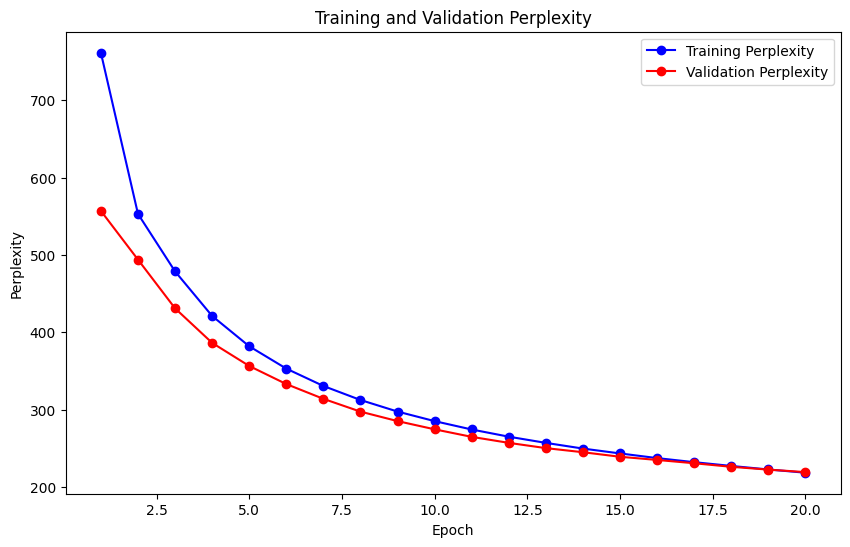

In [75]:
import matplotlib.pyplot as plt


epochs = range(1, 21)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_perplexities, 'bo-', label='Training Perplexity')
plt.plot(epochs, val_perplexities, 'ro-', label='Validation Perplexity')
plt.title('Training and Validation Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.legend()
plt.show()

### Bonus Questions:

In [26]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from collections import Counter
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from collections import Counter

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/genius/nltk_data...


True

In [28]:
def create_vocabulary(corpus, vocab_size):
    """
    Create vocabulary mapping from a corpus.
    """
    lemmatizer = WordNetLemmatizer()

    tokens = corpus.split()

    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # tokens = corpus.split()
    token_freqs = {}
    for token in lemmatized_tokens:
        token_freqs[token] = token_freqs.get(token, 0) + 1

    sorted_tokens = sorted(token_freqs.items(), key=lambda x: x[1], reverse=True)
    vocab = {"<unk>": 0}
    for i, (token, _) in enumerate(sorted_tokens):
        if i >= vocab_size - 1:  # Reserve a spot for <unk>
            break
        vocab[token] = len(vocab)
    return vocab

In [47]:
def corpus_to_int(corpus, vocab):
    """
    Convert a corpus to its integer representation using a vocabulary mapping.
    """
    tokens = corpus.split()
    return [vocab.get(token, 0) for token in tokens]  # Default to 0 if token is <unk>

In [51]:
vocab_size = 10000
vocab = create_vocabulary(corpus, vocab_size)

In [48]:
train_corpus = read_corpus(["wiki2.train.txt"])
train_int = corpus_to_int(train_corpus, vocab)

val_corpus = read_corpus(["wiki2.valid.txt"])
val_int = corpus_to_int(val_corpus, vocab)

test_corpus = read_corpus(["wiki2.test.txt"])
test_int = corpus_to_int(test_corpus, vocab)

In [49]:
sequence_length = 20
batch_size = 64  # Example batch size
train_dataset = WikiDataset(train_int, sequence_length)
val_dataset = WikiDataset(val_int, sequence_length)
test_dataset = WikiDataset(test_int, sequence_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [52]:
embedding_dim = pretrained_embeddings.dim  
weights_matrix = torch.zeros((len(vocab)+1, embedding_dim))

# Fill in the weights matrix with GloVe vectors where available
for word, idx in vocab.items():
    if word in pretrained_embeddings.stoi:
        weights_matrix[idx] = pretrained_embeddings.vectors[pretrained_embeddings.stoi[word]]
    else:
        weights_matrix[idx] = torch.randn(embedding_dim)  # Random initialization for unknown words

# Create an embedding layer and load the pre-trained weights
embedding_layer = nn.Embedding(len(vocab)+1, embedding_dim)
embedding_layer.load_state_dict({'weight': weights_matrix})

<All keys matched successfully>

In [53]:
vocab_size = len(vocab) + 1
embedding_dim = 100
hidden_dim = 128
dropout_prob = 0.2
time_steps = 20
batch_size = 64
learning_rate = 0.0001
epochs = 20

# Model initialization
model = RNNModel(vocab_size, pretrained_embeddings.dim, hidden_dim, vocab_size, weights_matrix).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()


device = torch.device('cpu')
model.to(device)

RNNImproved(
  (embedding): Embedding(10000, 100)
  (rnn): RNN(100, 128, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=10000, bias=True)
)

In [54]:
def evaluate(model, data_loader, loss_fn, device):
    model.eval()  
    total_loss = 0
    with torch.no_grad():  
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)

           
            batch_size_current = inputs.size(0)
            hidden = model.init_hidden(batch_size_current).to(device)

            logits, _ = model(inputs, hidden)
            loss = loss_fn(logits.transpose(1, 2), targets)  
            total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    perplexity = torch.exp(torch.tensor(avg_loss)).item()
    return avg_loss, perplexity

train_losses, train_perplexities = [], []
val_losses, val_perplexities = [], []
for epoch in range(epochs):
    model.train() 
    total_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        batch_size_current = inputs.size(0)
        hidden = model.init_hidden(batch_size_current).to(device)

        model.zero_grad()
        logits, hidden = model(inputs, hidden)
        hidden = hidden.detach()
        loss = criterion(logits.transpose(1, 2), targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_perplexity = torch.exp(torch.tensor(avg_train_loss)).item()
    train_perplexities.append(train_perplexity)

    val_loss, val_perplexity = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_perplexities.append(val_perplexity)

    print(f'Epoch {epoch+1}/{epochs}, '
          f'Train Loss: {avg_train_loss:.4f}, Train Perplexity: {train_perplexity:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Perplexity: {val_perplexity:.4f}')

Epoch 1/20, Train Loss: 6.3407, Train Perplexity: 567.1971, Val Loss: 5.9837, Val Perplexity: 396.9152
Epoch 2/20, Train Loss: 5.9709, Train Perplexity: 391.8463, Val Loss: 5.8648, Val Perplexity: 352.4068
Epoch 3/20, Train Loss: 5.8326, Train Perplexity: 341.2427, Val Loss: 5.7312, Val Perplexity: 308.3260
Epoch 4/20, Train Loss: 5.7118, Train Perplexity: 302.4142, Val Loss: 5.6364, Val Perplexity: 280.4554
Epoch 5/20, Train Loss: 5.6269, Train Perplexity: 277.7957, Val Loss: 5.5660, Val Perplexity: 261.3925
Epoch 6/20, Train Loss: 5.5610, Train Perplexity: 260.0865, Val Loss: 5.5105, Val Perplexity: 247.2764
Epoch 7/20, Train Loss: 5.5071, Train Perplexity: 246.4413, Val Loss: 5.4621, Val Perplexity: 235.5889
Epoch 8/20, Train Loss: 5.4597, Train Perplexity: 235.0328, Val Loss: 5.4225, Val Perplexity: 226.4419
Epoch 9/20, Train Loss: 5.4183, Train Perplexity: 225.4856, Val Loss: 5.3830, Val Perplexity: 217.6702
Epoch 10/20, Train Loss: 5.3814, Train Perplexity: 217.3361, Val Loss: 5.

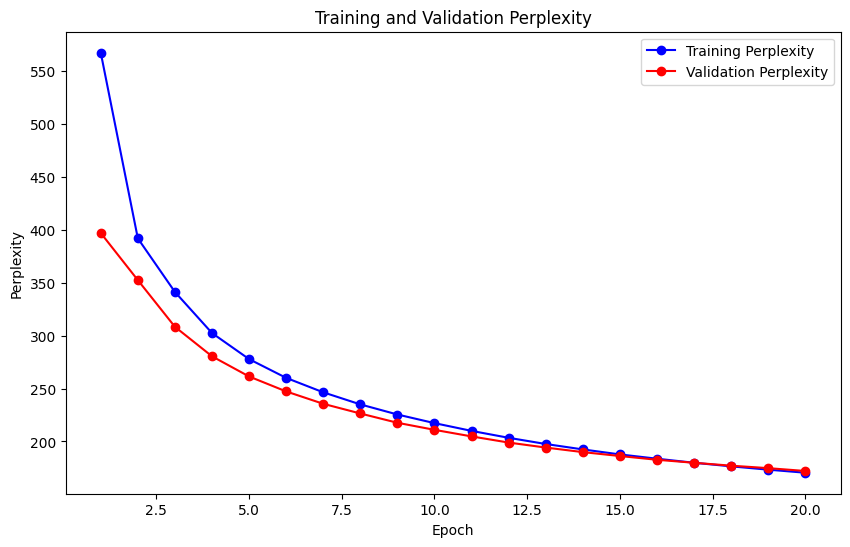

In [55]:
import matplotlib.pyplot as plt


epochs = range(1, 21)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_perplexities, 'bo-', label='Training Perplexity')
plt.plot(epochs, val_perplexities, 'ro-', label='Validation Perplexity')
plt.title('Training and Validation Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.legend()
plt.show()

In [56]:
# save the model
model_path = 'model.pth'
torch.save(model.state_dict(), model_path)

In [57]:
def evaluate_perplexity(model, data_loader, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    loss_fn = nn.CrossEntropyLoss()

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            
            batch_size_current = inputs.size(0)
            hidden = model.init_hidden(batch_size_current).to(device)

           
            outputs, _ = model(inputs, hidden)
            loss = loss_fn(outputs.transpose(1, 2), targets)  

            total_loss += loss.item() * inputs.size(0) 

    avg_loss = total_loss / len(data_loader.dataset) 


    perplexity = torch.exp(torch.tensor(avg_loss))
    return perplexity.item()


test_perplexity = evaluate_perplexity(model, test_loader, device)
print(f'Test Perplexity: {test_perplexity}')

Test Perplexity: 163.32322692871094
